<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Abschnitt_7_Food_vision_blog/07_milestone_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

## Check GPU

* Google Colab offers free GPUs, however, not all of them ar compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we´re using our own hardware, our GPU need a score of 7.0+.

In [2]:
!pip install tensorflow==2.4.1

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f184e0b7-6d26-d507-8d2e-6087cafe3893)


## Get helper functions

In [4]:
# Download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-03 13:46:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-03 13:46:45 (99.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download Data

In [6]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [7]:
# List all available datasets
datasets_list = tfds.list_builders() #get all available datasets in TFDS
print("food101" in datasets_list)

True


In [8]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", split=["train", "validation"], 
                                             shuffle_files=True, 
                                             as_supervised=True, #gets data returned in tuple format (data, label)
                                             with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete53FF81/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete53FF81/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

We want to find:
* Class names
* Shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (one hot hot encoded or label encoded?)
* Do the labels match up with the class names?


In [9]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
# Take one sample of the train data
train_one_sample = train_data.take(1) #samples are in format (image_tensor, label)

In [12]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [13]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor format): {label}
  Class name (str format): {class_names[label.numpy()]}
  """)


  Image shape: (512, 384, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor format): 80
  Class name (str format): pulled_pork_sandwich
  


In [14]:
# What does our image tensor from TFDS´s Food 101 look like?
image

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[ 16,  15,  20],
        [ 10,   9,  14],
        [  5,   5,   7],
        ...,
        [  4,   7,  14],
        [  6,   9,  16],
        [  7,  10,  17]],

       [[  9,   8,  13],
        [  9,   8,  13],
        [  8,   8,  10],
        ...,
        [  5,   8,  15],
        [  6,   9,  16],
        [  9,  12,  19]],

       [[  7,   6,  11],
        [ 11,  10,  15],
        [ 15,  15,  17],
        ...,
        [  7,   7,  15],
        [  3,   6,  15],
        [  5,   8,  17]],

       ...,

       [[ 75,  39,  17],
        [ 74,  38,  14],
        [ 79,  44,  22],
        ...,
        [109,  84,  80],
        [ 91,  63,  60],
        [ 96,  68,  64]],

       [[ 84,  49,  29],
        [ 77,  42,  20],
        [ 69,  34,  14],
        ...,
        [ 97,  72,  68],
        [ 93,  65,  62],
        [103,  75,  72]],

       [[ 84,  49,  29],
        [ 76,  41,  21],
        [ 66,  31,  11],
        ...,
        [ 96,  70,  6

In [15]:
#What are the min and max values of our image tensors?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow dataset

(-0.5, 383.5, 511.5, -0.5)

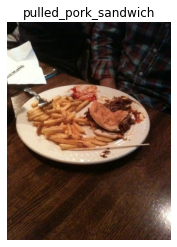

In [16]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) #Add title to image
plt.axis(False)

## Create preprocessing functions for our data

NN perform best when data is in a certain way (e.g. batched, normalized, etc.)

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you´ll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In uint8 dtype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixels values are between 0&255)

What we know models like:
* Data in float32 dtype (or for mixed precision float16 and float32)
* For batches, TensorFlow likes all of the tensors within a batch to be the same size
* Scaled (values between 0 & 1) also calles normalized tensors generally performs better

With these points in mind, we´ve got a few things we can tackle with a preprocessing function.

Since we´re going to be using an EfficientNetBX pretrained model from tf.keras.application we don´t need to rescale our data (these architectures have rescaling build-in)

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from uint8 to float 32

In [17]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  #image = image/255. #not required for Efficientnet
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [18]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[16 15 20]
  [10  9 14]
  [ 5  5  7]
  ...
  [ 4  7 14]
  [ 6  9 16]
  [ 7 10 17]]

 [[ 9  8 13]
  [ 9  8 13]
  [ 8  8 10]
  ...
  [ 5  8 15]
  [ 6  9 16]
  [ 9 12 19]]]...,
Shape: (512, 384, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[10.734694   9.734694  14.734694 ]
  [ 6.9030614  6.9030614  8.903062 ]
  [ 6.908163   6.908163   8.908163 ]
  ...
  [10.44894   11.877529  17.306118 ]
  [ 4.800982   7.800982  14.8009815]
  [ 7.469378  10.4693775 17.469378 ]]

 [[ 9.357143   8.357143  13.357143 ]
  [14.994898  14.994898  16.994898 ]
  [11.785715  11.785715  13.785715 ]
  ...
  [ 9.596945   9.596945  17.596945 ]
  [ 7.2295356  7.2295356 15.229536 ]
  [ 3.0918357  6.091836  15.091836 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & for prepare datasets

We´re now going to make our data input pipeline run really fast.

In [19]:
#Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

#Map preprocessing function to the test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

Hey TensorFlow, map this preprocessing function (preprocess_img) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch.

## Create modelling callbacks

We´re going to create a couple of callbacks:
* tensorBoard callback to log training results
* ModelCheckpoint callback to save our model´s progress after feature extraction

In [21]:
#Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

#Create ModelCheckpoint callback to save a model´s progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

##Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision.

Mixed precision utilizes a combination of float32 and float16 to speed up model performance.

In [22]:
# Turn on mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") #set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [23]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [26]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create base model
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
#Note: EfficientNetBX model have rescaling builz-in
# x = preprocessing.Rescaling(1./255)(x)

x = base_model(inputs, training=False) #make sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

#Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking layer dtype policies (are we using mixed prexision)?

In [28]:
#Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Goint through the above we see:
* layer.name: the human readable name of a particular layer
* layer.trainable: is the layer trainable or not?
* layer.dtype: the datatype a layer stores its variables in
* layer.dtype_policy: the data type policy a layer computes on its variables with

In [35]:
#Check the dtype_policy of layers in the base model
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple of output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [37]:
# Fit the feature extraction model with callbacks

history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20210803-141341
Epoch 1/3
2368/2368 [==============================] - 234s 83ms/step - loss: 2.3251 - accuracy: 0.4662 - val_loss: 1.2317 - val_accuracy: 0.6790


Epoch 2/3
2368/2368 [==============================] - 173s 72ms/step - loss: 1.3215 - accuracy: 0.6606 - val_loss: 1.1240 - val_accuracy: 0.6962


Epoch 3/3
2368/2368 [==============================] - 173s 73ms/step - loss: 1.1557 - accuracy: 0.6989 - val_loss: 1.0901 - val_accuracy: 0.7076


In [38]:
#Evaluate model on the whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 57s 72ms/step - loss: 1.0879 - accuracy: 0.7072


[1.0879058837890625, 0.7071683406829834]

## Challenge

We´ve covered a lot of ground so far but since this is a milestone project, it´s time to takeover.

Complete the TEMPLATE version of 07 to obtain a computer vision model to beat DeepFood paper.